In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import joblib
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import IPython.display
import os
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import math as m
import dask.diagnostics
import pandas as pd

/home/156/al1353/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
memory = joblib.Memory(cachedir='.')

In [3]:
expts = ['gfdl_nyf_1080_cp','gfdl_nyf_1080_SH','gfdl_nyf_1080_PI','gfdl_nyf_1080_UP']

### The aim of this part of simulation is to check whether our method of using 5-daily data is correct. The average of 73 5-daily data should be the same as the year average data. The 5-daily data has the eddies' effect. Firstly, we did the test by using the tx_trans. However, in the 5-daiy data, we do not have the tx_trans, so the basic idea is by using the velocity data and the resolution of the map to calculate the tx_trans and then do the average. Using this average value of calculated tx_trans to compare with the tx_trans in ocean.nc experiment to check robust the calculation method. The result gave a 20% error, which is a little bit high but acceptable

### The next step is to mask the tx_trans data we calculated and compare with the tx_trans_rho data in ocean.nc. In order to do this, we need to find out the density level of the tx_tran _rho and use the same density level to do the masking.

# 1. Constracting tx_trans by using five-daily data. (There is no tx_trans in 5-daily data)

## 1.1 Average of 73 tx_trans constructed by using 5-daily data.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


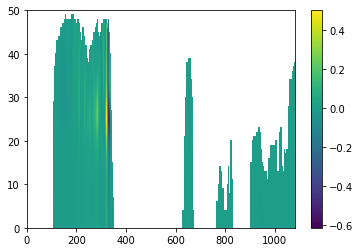

In [7]:

Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest')
udzt = np.zeros(dzt.shape)

oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
tx_trans_sum =0

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
    u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest')
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest')
    yt_ocean = eData.yt_ocean
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    tx_trans_sum = tx_trans_sum + tx_trans

tx_trans = tx_trans_sum/73

plt.pcolormesh(tx_trans)
plt.colorbar()

### The key problem to calculating the tx_trans in 5-daily experiments is that the velocity is in the u cells of the measurement and the dzt is in the t cell of the measurement so we need to do the reshaping of the data to transfer the data from u shell to t shell. Then we need to find out the real length of the distance bwteen 2 adjacent points on the measurement map. Finally, we can do the multiplication between dyt and udzt. 

## 1.2 Constructing a tx_trans by using a single 5-daily experiment.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


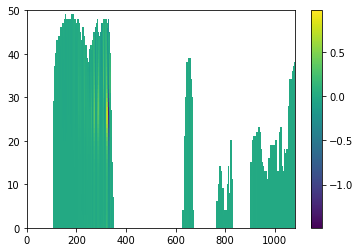

In [15]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output506'
File = 'ocean__506_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
rho = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest')
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest')
yt_ocean = eData.yt_ocean

# compute u.dzt
udzt = np.zeros(dzt.shape)
udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
udzt[:,0] = u.values[:,0]
udzt = udzt*dzt.values

#eData
dyt = np.gradient(yt_ocean.values)
dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6

tx_trans = dyt.values*udzt

plt.pcolormesh(tx_trans)
plt.colorbar()

# 2. tx_trans in ocean.nc file

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


(-70, -30)

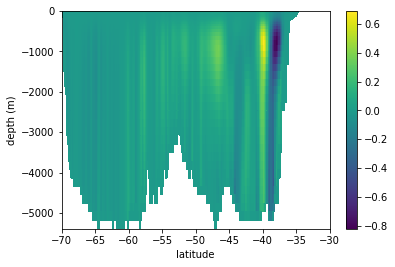

In [8]:
Folder3 = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File3 = 'ocean.nc'
FileName3 = os.path.join(Folder3,File3)
eData3 = xr.open_dataset(FileName3)
tx_trans_w = eData3.tx_trans.isel(time=0).sel(xu_ocean=20, method='nearest')
plt.pcolormesh(eData3.yt_ocean,-eData3.st_ocean,tx_trans_w)
plt.ylabel('depth (m)')
plt.xlabel('latitude')
plt.colorbar()
#tx_trans_w.plot.pcolormesh()
plt.xlim([-70,-30])

## 2.1 tx_trans in ocean.nc sum over the depth

(-70, -30)

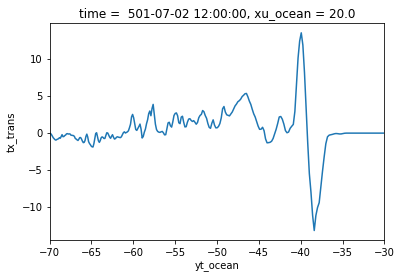

In [46]:
tx_trans_w.sum('st_ocean').plot()
plt.xlim([-70,-30])

## 2.2 The difference between the tx_trans we calculated and the tx_trans in ocean.nc file

0.0
<xarray.DataArray 'tx_trans' ()>
array(143.24074645465035)
Coordinates:
    time      object  501-07-02 12:00:00
    xu_ocean  float64 20.0


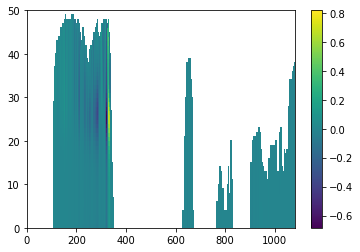

In [63]:
diff= tx_trans - tx_trans_w
plt.pcolormesh(diff)
plt.colorbar()
print(np.nansum(tx_trans[0:400]))
print(np.sum(tx_trans_w[0:400]))


After comparing the 5-daily data and the year average data, it gives us a 20 percents error, which is a little bit high and we are trying to figure that out.

# 3. Tx_trans_rho in ocean.nc file.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


(-70, -30)

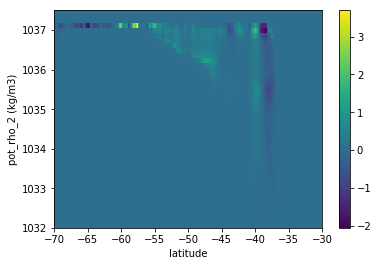

In [66]:
Folder3 = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File3 = 'ocean.nc'
FileName3 = os.path.join(Folder3,File3)
eData3 = xr.open_dataset(FileName3)
tx_trans_rho = eData3.tx_trans_rho.isel(time=0).sel(grid_xu_ocean=20, method='nearest')
#tx_trans_rho.plot.pcolormesh
plt.pcolormesh(eData3.yt_ocean,eData3.potrho,tx_trans_rho)
plt.colorbar()
#plt.pcolormesh(eData3.grid_yt_ocean,-eData3.st_ocean,tx_trans_rho)
plt.ylabel('pot_rho_2 (kg/m3)')
plt.xlabel('latitude')
plt.ylim([1032,1037.5])
plt.xlim([-70,-30])

## 3.1 Compare the tx_trans_rho sum over the density and the tx_trans sum over the depth. They are both from the ocean.nc file and they should look exactly same.

(-70, -30)

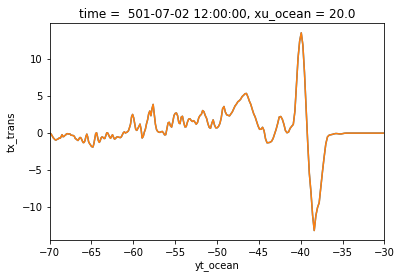

In [38]:
tx_trans_rho.sum('potrho').plot()
tx_trans_w.sum('st_ocean').plot()
plt.xlim([-70,-30])

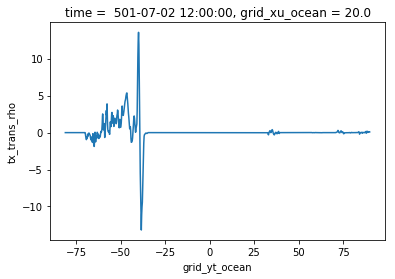

In [19]:
tx_trans_rho.sum('potrho').plot()

### The next step of the simulation is to use the potrho_edge data to do the masking on the 5-daily data in the range of [1037, 1032]. And then compare to the tx_trans_rho in the ocean.nc. Make sure to use the diff function to estiamte the difference.

In [ ]:
tx_trans_rho

In [ ]:
np.max(eData3.pot_rho_0)

In [ ]:
eData3.potrho_edges

In [ ]:
np.min(eData.pot_rho_2)

# 4. Mask of the 5-daily data

### Now we try to do the mask on the tx_trans in 5-daily data. The difficult part is how to figure out the axis problem.

## 4.1 Plot the contours of density on tx_trans in the ocean.nc file.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


<xarray.DataArray 'pot_rho_2' (st_ocean: 50, yt_ocean: 1080)>
array([[         nan,          nan,          nan, ...,  1036.161743,
         1036.112549,  1036.028687],
       [         nan,          nan,          nan, ...,  1036.161987,
         1036.113281,  1036.029175],
       [         nan,          nan,          nan, ...,  1036.162354,
         1036.114136,  1036.029907],
       ..., 
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
    xt_ocean  float64 20.12
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 -80.76 -80.65 -80.55 ...
    time      object  501-01-03 12:00:00
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 35.36 45.58 55.85 66.26 ...
    geolon_t  (yt_ocean) float64 ...
    geolat_t

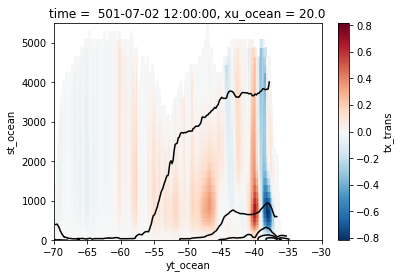

In [9]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest')
rho.plot.contour(levels=[1032,1033,1034,1035,1036,1037],colors='k')
tx_trans_w.plot()
plt.xlim([-70,-30])
print(rho)

## 4.2 Mask the u in 5-daily data and sum u over the depth

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


<xarray.DataArray 'u' (yu_ocean: 1080)>
array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
Coordinates:
    time      object  501-01-03 12:00:00
    xu_ocean  float64 20.0
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 -80.71 -80.6 -80.5 ...
    geolon_c  (yu_ocean) float64 ...
    geolat_c  (yu_ocean) float64 ...


(-70, -30)

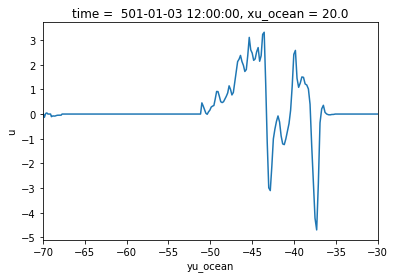

In [61]:
mask = ((rho.values < 1036) & (rho.values > 1035))
u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest')
umask = u*mask
ulayer = umask.sum('st_ocean')
#plt.pcolormesh(mask)
#plt.colorbar()
print(ulayer)
ulayer.plot()
plt.xlim([-70,-30])

## 4.3 Mask the  tx_trans calculated from the 5_daily data, in order to make into tx_trans_rho. And then compare.

###  4.3.1 Load the potrho_edges data

In [134]:
Folder3 = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File3 = 'ocean.nc'
FileName3 = os.path.join(Folder3,File3)
eData3 = xr.open_dataset(FileName3)
tx_trans_rho = eData3.tx_trans_rho.isel(time=0)
potrho_edges = eData3.potrho_edges
potrho = eData3.potrho
#tx_trans_sum = np.zeros(dzt.shape)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [135]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


### 4.3.2 Mask one single 5-daily data

In [8]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest')
u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest')
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest')
yt_ocean = eData.yt_ocean
tx_trans_sum = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20, method='nearest').shape)
# compute u.dzt
udzt = np.zeros(dzt.shape)
udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
udzt[:,0] = u.values[:,0]
udzt = udzt*dzt.values

#eData
dyt = np.gradient(yt_ocean.values)
dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6

tx_trans = dyt.values*udzt
    

for ii in range(80):
        
    mask = ((rho > potrho_edges[ii]) & (rho < potrho_edges[ii+1]))
    tx_trans_mask = tx_trans*mask
    tx_trans_sum[ii,:] = tx_trans_sum[ii,:] + tx_trans_mask.sum('st_ocean')
    
#tx_trans = tx_trans_sum/80

    

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


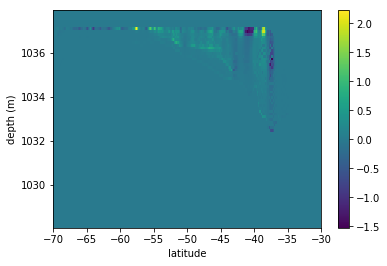

In [9]:
plt.pcolormesh(eData.yt_ocean,potrho,tx_trans_sum)
#rho1.plot.contour(levels=[1032], colors='k') # add the contour of the density
#rho1.plot.contour(levels=[1037.5], colors='k')
plt.ylabel('depth (m)')
plt.xlabel('latitude')
plt.xlim([-70,-30])
#plt.ylim([-1000,0])
plt.colorbar()

### 4.3.2.1 Vertical sum of the tx_trans_sum

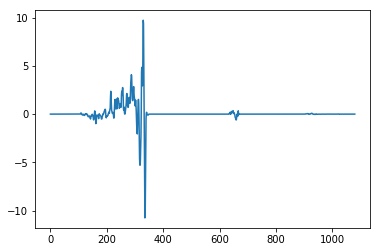

In [17]:
tx_trans_v = tx_trans_sum.sum(axis=0)
#plt.pcolormesh(eData.yt_ocean,tx_trans_v)
plt.plot(tx_trans_v)
#plt.xlim([-70,-30])

### The problem is that the dimensions of rho and prorho_edges are different. So I am thinking to use the layer of the pot_rho_2 to do the layer masking.

### 4.3.3 The average over all the 5-daily data for 1 year

In [80]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest')
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20, method='nearest').shape)
tx_trans_sum_av = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20, method='nearest').shape)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [7]:
for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest')
    
    
    u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest')
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest')
    yt_ocean = eData.yt_ocean
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    for ii in range(80):
        mask = ((rho > potrho_edges[ii]) & (rho < potrho_edges[ii+1]))
        tx_trans_mask = tx_trans*mask
        tx_trans_sum[ii,:] =  tx_trans_mask.sum('st_ocean')
    tx_trans_sum_av = tx_trans_sum_av + tx_trans_sum
    
tx_trans_rho_5 = tx_trans_sum_av/73

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [11]:
np.save('tx_trans_rho_5dav',tx_trans_rho_5)

In [64]:
tx_trans_rho_5 = np.load('tx_trans_rho_5dav.npy')

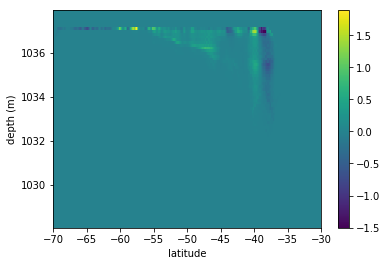

In [8]:
plt.pcolormesh(eData.yt_ocean,potrho,tx_trans_rho_5)
#rho1.plot.contour(levels=[1032], colors='k') # add the contour of the density
#rho1.plot.contour(levels=[1037.5], colors='k')
plt.ylabel('depth (m)')
plt.xlabel('latitude')
plt.xlim([-70,-30])
#plt.ylim([-1000,0])
plt.colorbar()

#plt.pcolormesh(tx_trans)
#plt.colorbar()

#plt.pcolormesh(eData.yt_ocean,-eData.st_ocean,tx_trans)
#rho1.plot.contour(levels=[1032], colors='k') # add the contour of the density
#rho1.plot.contour(levels=[1037.5], colors='k')
#plt.ylabel('depth (m)')
#plt.xlabel('latitude')
#plt.xlim([-70,-30])
#plt.ylim([-1000,0])
#plt.colorbar()

#plt.pcolormesh(tx_trans)
#plt.colorbar()

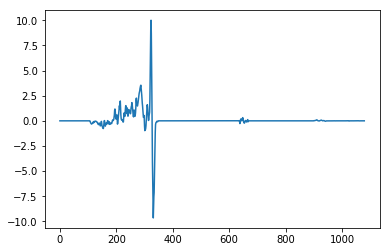

In [9]:
tx_trans_v_5 = tx_trans_rho_5.sum(axis=0)
#plt.pcolormesh(eData.yt_ocean,tx_trans_v)
plt.plot(tx_trans_v_5)
#plt.xlim([-70,-30])

### The problem of the average of the average of the tx_trans_rho is that it takes so long to run code.

### 4.3.4 The difference between tx_trans_rho in ocean.nc file and the average of the tx_trans_rho

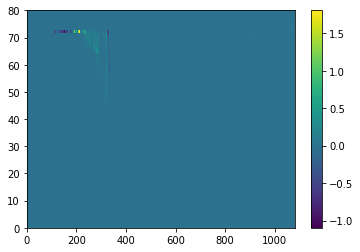

In [67]:
diff= tx_trans_rho - tx_trans_rho_5
plt.pcolormesh(diff)
plt.colorbar()

# 5. Select the correct region and calculate again.

In [136]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_1036 = np.zeros(dzt.shape)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [137]:
for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.6)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-8.973024753017057)
Coordinates:
    xt_ocean  float64 20.12
    time      object  501-12-29 12:00:00

(2000, 0)

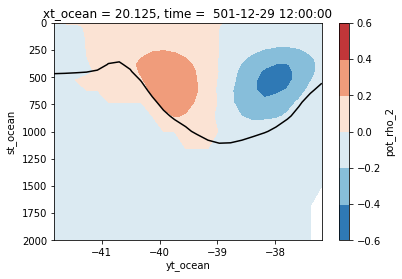

In [139]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.6], colors='k')

plt.ylim(2000, 0)

np.save('tx_trans_rho_5dav_c',tx_trans_rho_5_c)

In [130]:
rho.st_ocean

<xarray.DataArray 'st_ocean' (st_ocean: 50)>
array([  5.033550e+00,   1.510065e+01,   2.521935e+01,   3.535845e+01,
         4.557635e+01,   5.585325e+01,   6.626175e+01,   7.680285e+01,
         8.757695e+01,   9.862325e+01,   1.100962e+02,   1.221067e+02,
         1.349086e+02,   1.487466e+02,   1.640538e+02,   1.813125e+02,
         2.012630e+02,   2.247773e+02,   2.530681e+02,   2.875508e+02,
         3.300078e+02,   3.823651e+02,   4.467263e+02,   5.249824e+02,
         6.187031e+02,   7.286921e+02,   8.549935e+02,   9.967153e+02,
         1.152376e+03,   1.319997e+03,   1.497562e+03,   1.683057e+03,
         1.874788e+03,   2.071252e+03,   2.271323e+03,   2.474043e+03,
         2.678757e+03,   2.884898e+03,   3.092117e+03,   3.300086e+03,
         3.508633e+03,   3.717567e+03,   3.926813e+03,   4.136251e+03,
         4.345864e+03,   4.555566e+03,   4.765369e+03,   4.975209e+03,
         5.185111e+03,   5.395023e+03])
Coordinates:
    xt_ocean  float64 20.62
    time      object  

In [131]:
rho[23,1].values

array(1035.6561279296875)

In [132]:
rho[23,2].values

array(1035.669677734375)

In [ ]:
plt.plot(rho)

In [145]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_1036 = np.zeros(dzt.shape)
for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.1)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-5.3705059347794535)
Coordinates:
    xt_ocean  float64 20.12
    time      object  501-12-29 12:00:00

(1000, 0)

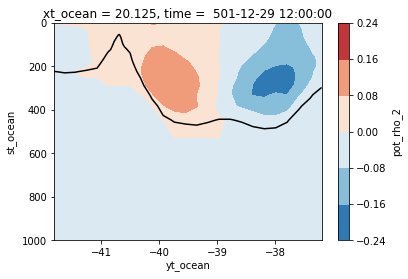

In [144]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.1], colors='k')

plt.ylim(1000, 0)

## 5.1 Robust the results

In [146]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=19, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=19, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_sum_av_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=19, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=19, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=19, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=19, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.6)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
    

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans


/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-11.49851225677888)
Coordinates:
    xt_ocean  float64 19.12

(2000, 0)

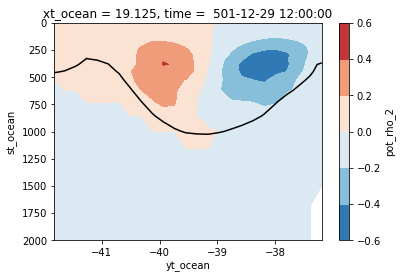

In [147]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.6], colors='k')

plt.ylim(2000, 0)

In [149]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=19, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=19, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_sum_av_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=19, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=19, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=19, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=19, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.1)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
    

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-19.41772152948653)
Coordinates:
    xt_ocean  float64 19.12

(1000, 0)

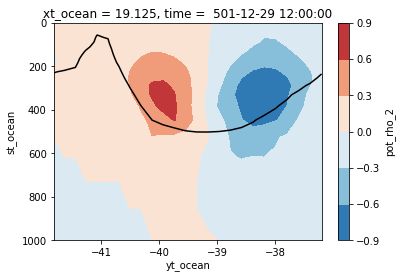

In [150]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.1], colors='k')

plt.ylim(1000, 0)

In [151]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=21, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=21, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_sum_av_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=21, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=21, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=21, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=21, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.6)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
    

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans


/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-27.76860718556652)
Coordinates:
    xt_ocean  float64 21.12
    time      object  501-12-29 12:00:00

(1200, 0)

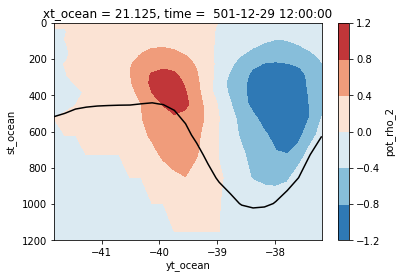

In [152]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.6], colors='k')

plt.ylim(1200, 0)

In [153]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=21, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=21, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_sum_av_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=21, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=21, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=21, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=21, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.1)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
    

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-32.44041680414156)
Coordinates:
    xt_ocean  float64 21.12

(1000, 0)

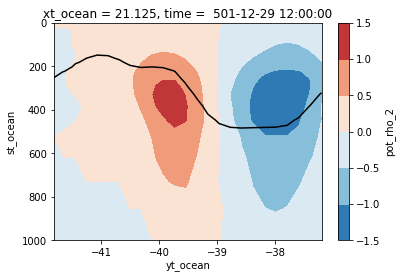

In [154]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.1], colors='k')

plt.ylim(1000, 0)

In [124]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=22, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=22, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_sum_av_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=22, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=22, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=22, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=22, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1036)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
    

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans


/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-19.064961248618218)
Coordinates:
    xt_ocean  float64 22.12
    time      object  501-12-29 12:00:00

(1200, 0)

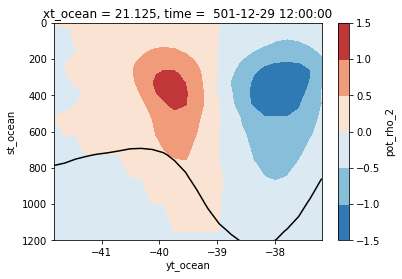

In [156]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1036], colors='k')

plt.ylim(1200, 0)

In [157]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=22, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=22, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_sum_av_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=22, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=22, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=22, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=22, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.1)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
    

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-28.49588780559281)
Coordinates:
    xt_ocean  float64 22.12
    time      object  501-12-29 12:00:00

(1200, 0)

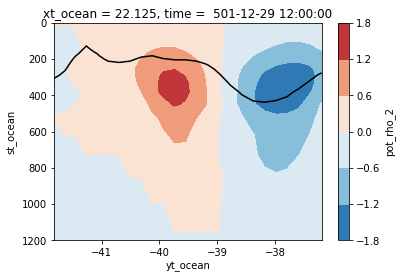

In [158]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.1], colors='k')

plt.ylim(1200, 0)

In [126]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20.5, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20.5, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_sum_av_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20.5, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20.5, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=20.5, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20.5, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.6)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
    

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans


/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-30.140921261725367)
Coordinates:
    xt_ocean  float64 20.62

(1200, 0)

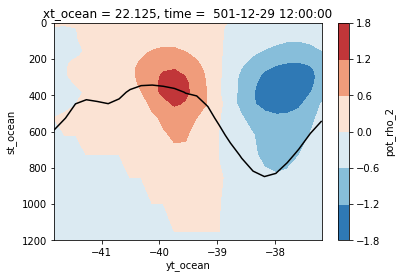

In [160]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.6], colors='k')

plt.ylim(1200, 0)

In [161]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20.5, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20.5, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_sum_av_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20.5, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)

for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20.5, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=20.5, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20.5, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.1)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73
    

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.DataArray 'pot_rho_2' ()>
array(-34.2115853335564)
Coordinates:
    xt_ocean  float64 20.62

(1200, 0)

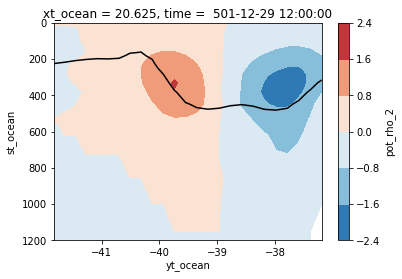

In [162]:
plt.figure
tx_trans_rho_5_c.plot.contourf()
rho.plot.contour(levels=[1035.1], colors='k')

plt.ylim(1200, 0)

# 6. Time series for the 5-daily data

In [163]:
Folder_e = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP'
File_e = 'output501'
FileName_e = os.path.join(Folder_e,File_e)
eData_e = xr.open_dataset(FileName_e)

oceanList = [f for f in os.listdir(Folder) if f.startswith('output5')]
oceanList.sort()

OSError: [Errno -51] NetCDF: Unknown file format: b'/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'

In [ ]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output501'
File = 'ocean__501_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_1036 = np.zeros(dzt.shape)
for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.1)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73

np.save('tx_trans_rho_5_y1',tx_trans_rho_5_c)

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans

In [ ]:
Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/output502'
File = 'ocean__502_003.nc'
FileName = os.path.join(Folder,File)
eData = xr.open_dataset(FileName)
dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
tx_trans_1036 = np.zeros(dzt.shape)
for File in oceanList:
    FileName = os.path.join(Folder,File)
    #print(FileName)
    eData = xr.open_dataset(FileName)
    rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    
    u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
    udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
    udzt[:,0] = u.values[:,0]
    udzt = udzt*dzt.values
    dyt = np.gradient(yt_ocean.values)
    dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
    tx_trans = dyt.values*udzt
    
    mask = (rho < 1035.1)
    tx_trans_mask = tx_trans*mask
    tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
tx_trans_rho_5_c = tx_trans_1036/73

np.save('tx_trans_rho_5_y2',tx_trans_rho_5_c)

AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
AL_trans

In [172]:
#@memory.cache
def five_d_y(yer):
    Folder = '/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/outputyer'
    File = 'ocean__yer_003.nc'
    FileName = os.path.join(Folder,File)
    eData = xr.open_dataset(FileName)
    dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
#u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37))
    udzt = np.zeros(dzt.shape)
#rho1 = eData.pot_rho_2.isel(time=0).isel(st_ocean=0)
    oceanList = [f for f in os.listdir(Folder) if f.startswith('ocean__')]
    oceanList.sort()
#tx_trans_sum = np.zeros(dzt.shape)
    tx_trans_sum_c = np.zeros(tx_trans_rho.sel(grid_xu_ocean=20, method='nearest').sel(grid_yt_ocean=slice(-42, -37)).shape)
    tx_trans_1036 = np.zeros(dzt.shape)
    for File in oceanList:
        FileName = os.path.join(Folder,File)
    #print(FileName)
        eData = xr.open_dataset(FileName)
        rho = eData.pot_rho_2.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
    
        u = eData.u.isel(time=0).sel(xu_ocean=20, method='nearest').sel(yu_ocean=slice(-42,-37)).isel(yu_ocean=slice(1,26))
        dzt = eData.dzt.isel(time=0).sel(xt_ocean=20, method='nearest').sel(yt_ocean=slice(-42,-37))
        yt_ocean = eData.yt_ocean.sel(yt_ocean=slice(-42,-37))
    
        udzt[:,1:] = 0.5*(u.values[:,:-1]+u.values[:,1:])
        udzt[:,0] = u.values[:,0]
        udzt = udzt*dzt.values
        dyt = np.gradient(yt_ocean.values)
        dyt = dyt*110000*np.cos(yt_ocean*m.pi/180)*10**-6
        tx_trans = dyt.values*udzt
    
        mask = (rho < 1035.1)
        tx_trans_mask = tx_trans*mask
        tx_trans_1036 = tx_trans_1036 + tx_trans_mask
    
    tx_trans_rho_5_c = tx_trans_1036/73

    #np.save('tx_trans_rho_5_x',tx_trans_rho_5_c)

    AL_trans = tx_trans_rho_5_c.sum(axis=0).sum(axis=0)
    return AL_trans


In [173]:
for yer in range(501,551):
    AL_trans = five_d_y(yer)
    print(AL_trans)


FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/v45/APE-MOM/gfdl_nyf_1080_UP/outputyer/ocean__yer_003.nc'

In [26]:
tx_trans_rho_5.shape

(80, 1080)

In [31]:
data=np.load('tx_trans_rho_5dav.npy')

In [32]:
locs = ['IA', 'IL', 'IN']

In [40]:
times = pd.date_range('2016-12-29', periods=80)

In [41]:
foo = xr.DataArray(data, coords=[times, locs], dims=['time', 'space'])

ValueError: conflicting sizes for dimension 'space': length 1080 on the data but length 3 on coordinate 'space'

### Today, I mainly do the masking of the tx_trans

### The things I need to do tomorrow are:

1. load potrho_edges correctly.

2. Initialize the tx_trans_sum correctly.

3. loop over all the nrho.

The result should the same as the tx_trans_rho and then we can do the average thing.



### The next step is to do the tx_trans in salt. And then we can do the estimation on the wind sensitivity.